In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM

In [14]:
df = pd.read_csv("SMSSpamCollection.csv", sep ='\t',names=["label", "message"])

In [15]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [17]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

# "Wordcloud"
### Found this awesome library to visualize common words in spam and ham messages.

In [19]:
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())



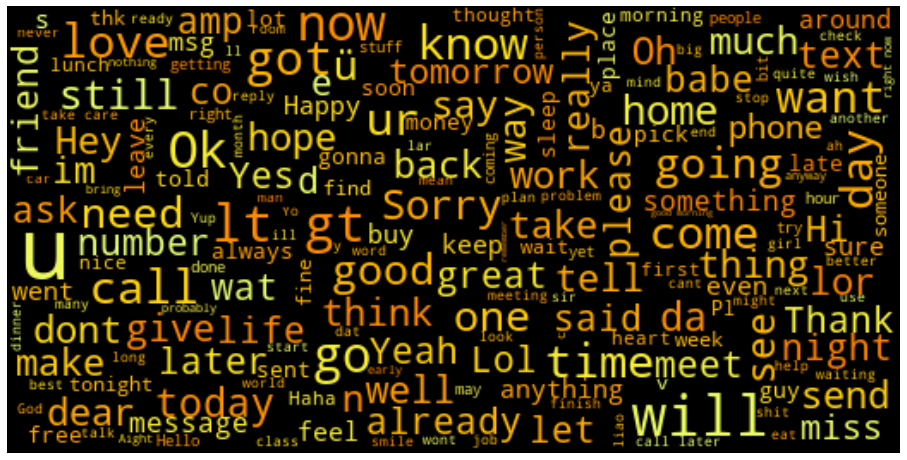

In [20]:
#Visualizing common words in ham texts.
ham_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Wistia').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

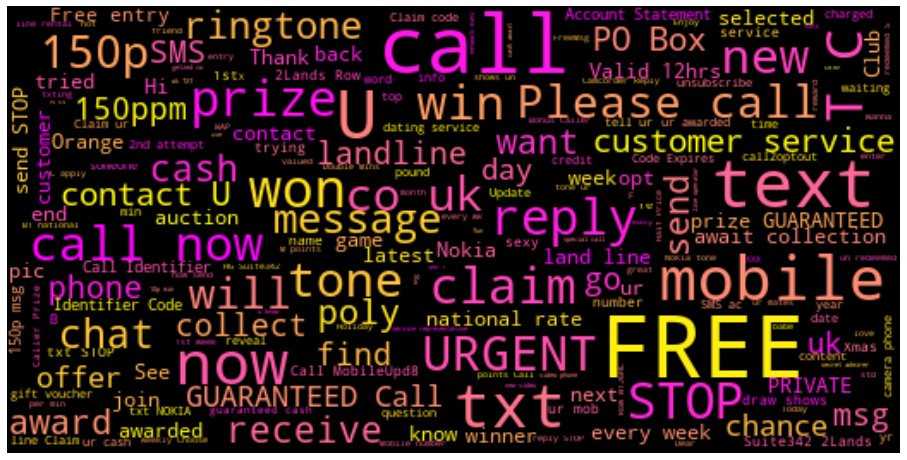

In [21]:
#Visualizing common words in spam texts.
spam_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='spring').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

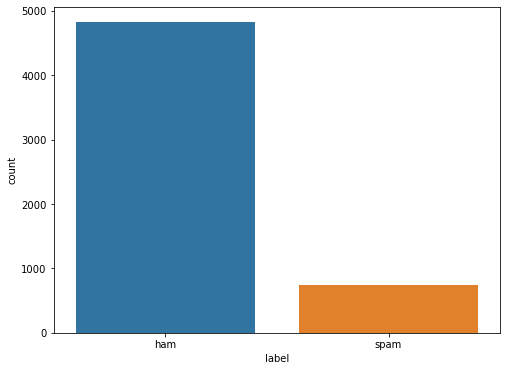

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)

In [24]:
#we will downsample the ham dataset to create balanced data
ham_msg_df = ham_msg.sample(n = 1000, random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(1000, 2) (747, 2)


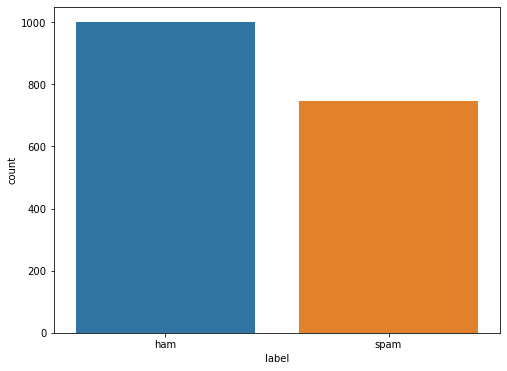

In [25]:
#now they are comparable almost.
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)###final data frame for training!
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)

In [26]:
msg_df['text_length'] = msg_df['message'].apply(len)
print(msg_df.tail())
msg_df.groupby('label').mean()

     label                                            message  text_length
1742  spam  Want explicit SEX in 30 secs? Ring 02073162414...           90
1743  spam  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...          158
1744  spam  Had your contract mobile 11 Mnths? Latest Moto...          160
1745  spam  REMINDER FROM O2: To get 2.50 pounds free call...          147
1746  spam  This is the 2nd time we have tried 2 contact u...          160


,text_length
label,
ham,72.433000
spam,138.670683


In [27]:
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})

In [28]:
msg_label = msg_df['msg_type'].values

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=101)

In [30]:
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [31]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [32]:
word_index = tokenizer.word_index
#word_index

In [33]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [34]:
print(training_padded[0])

[327  20  69  61   1 105   6 416  34   1  37 167   6   7   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## using "Dense Layer"

In [74]:
embeding_dim = 16
drop = 0.2 

In [75]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(1, activation='sigmoid'))

In [92]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [93]:
alarm = EarlyStopping(monitor='val_loss', patience=3)
model.fit(training_padded, Y_train, epochs=30, validation_data=(testing_padded, Y_test),callbacks =[alarm], verbose=2)

Epoch 1/30
44/44 - 1s - loss: 0.0472 - accuracy: 0.9843 - val_loss: 0.1110 - val_accuracy: 0.9629
Epoch 2/30
44/44 - 0s - loss: 0.0499 - accuracy: 0.9828 - val_loss: 0.1093 - val_accuracy: 0.9629
Epoch 3/30
44/44 - 0s - loss: 0.0495 - accuracy: 0.9850 - val_loss: 0.1133 - val_accuracy: 0.9657
Epoch 4/30
44/44 - 0s - loss: 0.0436 - accuracy: 0.9871 - val_loss: 0.1168 - val_accuracy: 0.9657
Epoch 5/30
44/44 - 0s - loss: 0.0424 - accuracy: 0.9871 - val_loss: 0.1166 - val_accuracy: 0.9657


In [94]:
model.evaluate(testing_padded, Y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.1166 - accuracy: 0.9657


[0.11656452715396881, 0.9657142758369446]

## using "LSTM"

In [96]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(20, dropout=0.2, return_sequences=True))
model1.add(LSTM(20, dropout=0.3, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [97]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [98]:
num_epochs = 30
alarm = EarlyStopping(monitor='val_loss', patience=3)
history = model1.fit(training_padded, Y_train, epochs=num_epochs, validation_data=(testing_padded, Y_test),callbacks =[], verbose=2)

Epoch 1/30
44/44 - 5s - loss: 0.6463 - accuracy: 0.6154 - val_loss: 0.5198 - val_accuracy: 0.8031
Epoch 2/30
44/44 - 1s - loss: 0.3823 - accuracy: 0.8795 - val_loss: 0.3151 - val_accuracy: 0.8985
Epoch 3/30
44/44 - 1s - loss: 0.2633 - accuracy: 0.9218 - val_loss: 0.2479 - val_accuracy: 0.9250
Epoch 4/30
44/44 - 1s - loss: 0.2055 - accuracy: 0.9390 - val_loss: 0.2179 - val_accuracy: 0.9303
Epoch 5/30
44/44 - 1s - loss: 0.1784 - accuracy: 0.9456 - val_loss: 0.2375 - val_accuracy: 0.9242
Epoch 6/30
44/44 - 1s - loss: 0.1650 - accuracy: 0.9488 - val_loss: 0.1982 - val_accuracy: 0.9327
Epoch 7/30
44/44 - 1s - loss: 0.1394 - accuracy: 0.9566 - val_loss: 0.1992 - val_accuracy: 0.9314
Epoch 8/30
44/44 - 1s - loss: 0.1292 - accuracy: 0.9584 - val_loss: 0.1965 - val_accuracy: 0.9329
Epoch 9/30
44/44 - 1s - loss: 0.1155 - accuracy: 0.9616 - val_loss: 0.2264 - val_accuracy: 0.9294
Epoch 10/30
44/44 - 1s - loss: 0.1131 - accuracy: 0.9615 - val_loss: 0.2093 - val_accuracy: 0.9289
Epoch 11/30
44/44 -

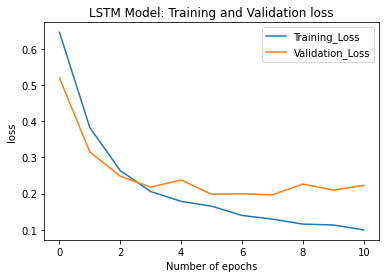

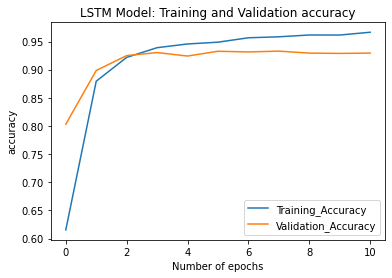

In [101]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Dense works better than LSTM !